### Метрики качества классификации.

Сегодня мы научимся использовать различные метрики для оценки качества моделей.

Для начала загрузим данные с предыдущей домашней задачи с небольшим `сюрпризом`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("processed_train.csv")

In [3]:
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Один из гномов очень завидовал своим братьям, переплюнувшим его по `accuracy` в бонусном задании предыдущей домашней работы. Поэтому совершил следующее злодеяние: выкинул кучу объектов таким образом, чтобы баланс классов нарушился! 

`Может, accuracy у них станет еще больше, зато преподаватель их отругает, ведь использовать accuracy при дисбалансе не очень-то хорошо!` - подумал гном

Замерьте количество объектов в порченном датафрейме.
В какой пропорции соотносятся классы теперь?

In [5]:
data.HasDetections.value_counts()

0    99940
1    20012
Name: HasDetections, dtype: int64

Произведем процедуру отложенной выборки:

In [6]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     shuffle=True, 
                                                     random_state=1)

Обучите логистическую регрессию с параметром `l2` регуляризации `C = 0.01` на порченном датасете.
Замерьте долю верно классифицированных объектов на трейне и на тесте. Можете использовать абсолютно любые конструкции, главное не забыть пронормировать данные с помощью `StandardScaler`

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# create a logistic regression model
lr = LogisticRegression(penalty='l2', C=0.01)

# fit the model
lr.fit(X_scaled, y_train)

# predict the test set
train_pted  = lr.predict(X_scaled)
test_pred = lr.predict(scaler.transform(X_test))

# calculate the accuracy
train_acc = np.mean(train_pted == y_train)
test_acc = np.mean(test_pred == y_test)

# print the results
print('Train accuracy: %.3f' % train_acc)
print('Test accuracy: %.3f' % test_acc)

Train accuracy: 0.841
Test accuracy: 0.842


Кажется, что, по сравнению с результатами в предыдущей домашней работе, мы построили куда более сильную модель. Но мы сильно заблуждаемся, если в это верим!

**Задание 2.**
Для бинарной классификации можно построить так называемую **confision matrix** (матрица ошибок), которая подсчитывает количество правильных и неправильных предсказаний и разделяет их по двум классам:

|          | a(x) = -1  | a(x) = +1  |
|----------|------------|------------|
|  y = -1  |     TN     |     FP     |
|  y = +1  |     FN     |     TP     |

* Positive/Negative отражает то, к какому классу определила объект наша модель $a(x)$, в нашем случае нулевой класс соответствует Negative (нет вируса), а единичный класс - Positive (есть вирус).

* True/False просто показывает совпало ли предсказание модели с реальным классом объекта, поэтому на главной диагонали стоят True, а на побочной False.

**2.1)** Постройте вручную матрицу ошибок на тестовой выборке, используя реальные и предсказанные вашей моделью метки классов. Потом сравните результат с методом `confusion_matrix` в `sklearn`.

In [9]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline

# create a pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(penalty='l2', C=0.01))])

# fit the pipeline
pipe.fit(X_train, y_train)
pred_test = pipe.predict(X_test)

# calculate the confusion matrix for the test set predictions
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()

print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 24726
False Positives: 293
False Negatives: 4442
True Positives: 527


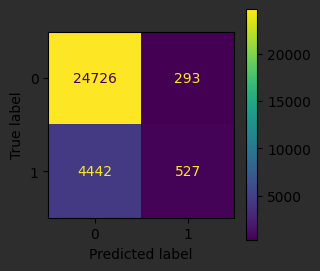

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)

cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(3,3))
cmp.plot(ax=ax)

plt.show()

Решаем вручную

In [10]:
# calculate the number of true positives (TP)
tp = ((pred_test == 1) & (y_test == 1)).sum()

# calculate the number of false positives (FP)
fp = ((pred_test == 1) & (y_test == 0)).sum()

# calculate the number of false negatives (FN)
fn = ((pred_test == 0) & (y_test == 1)).sum()

# calculate the number of true negatives (TN)
tn = ((pred_test == 0) & (y_test == 0)).sum()

print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Negatives: {tn}")


True Positives: 527
False Positives: 293
False Negatives: 4442
True Negatives: 24726


**2.2)** Посчитайте стандартную метрику Accuracy на тестовой выборке c помощью матрицы ошибок. Напомним, что это просто доля верно предсказанных меток:
$
ACC = \dfrac{TP + TN}{TP + TN + FP + FN}
$.

(Не стоит переводить accuracy как точность, так как под точностью иногда еще понимают precision, который является совсем другим показателем! Лучше всегда использовать английские версии метрик, чтобы не возникало недопониманий. )

In [12]:
# Calculate the accuracy
acc = (tp + tn) / (tp + tn + fp + fn)

print(f"Accuracy: {acc}")


Accuracy: 0.8421035080698946


Мы ожидаем, что полученная accuracy совпадет с той, что была подсчитана во время использования функции `cross_validate`

Мы знаем, что accuracy не является хорошим показателем качества модели при несбалансированных классах. 

Допустим у нас 1000 объектов, где 990 имеют метку класса 0, а остальные 10 имеют метку 1. В нашем случае, класс 0 соответствует компьютерам, на которых нет вируса, а класс 1 - на которых есть. Тогда accuracy у константной модели, которая всегда предсказывает нулевой класс будет $0.99$, хотя задача как раз состоит в том, чтобы детектировать эти самые 10 объектов, которые соответствуют зараженным компьютерам. 

При несбалансированных выборках с помощью матрицы ошибок можно посчитать следующие метрики:

* **Precision** показывает "точность" попадания нашего классификатора в положительный класс, то есть долю правильно предсказанных положительных объектов среди всех **предсказанных** положительных объектов. 

* **Recall** показывает "полноту" предсказаний нашего классификатора, то есть долю правильно предсказанных положительных объектов среди всех **реальных** положительных объектов.

**2.3)** Посчитайте Precision и Recall с помощью матрицы ошибок. Потом сравните с реализацией в sklearn. Напомним формулы из лекции:

$$
Precision = \dfrac{TP}{TP + FP}, \quad Recall = \dfrac{TP}{TP + FN}
$$

In [13]:
from sklearn.metrics import recall_score, precision_score

# Calculate the precision
precision = tp / (tp + fp)

# Calculate the recall
recall = tp / (tp + fn)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.6426829268292683
Recall: 0.10605755685248541


Теперь картина кажется не такой уж лучезарной!

Вспомним, 

Метод `.predict` на самом деле берёт предсказанные вероятности для каждого класса и каждому объекту присваивает тот класс, у которого больше вероятность. 

Так как мы сейчас занимаемся бинарной классификацией, то большая вероятность определяется просто сравнением с порогом 0.5.

**2.4)** Воспользуйтесь методом `.predict_proba` и с помощью сравнения с порогом 0.5 постройте вектор предсказаний. Проверьте результат на ранее предсказанных метках, вектора должны совпадать.

In [18]:
# predict the probabilities of belonging to each class for the test set
proba_test = pipe.predict_proba(X_test)

# create a vector of predicted labels based on the probabilities and the threshold of 0.5
pred_test = np.where(proba_test[:, 1] > 0.5, 1, 0)

# compare the predicted labels with the previously predicted labels
print(np.array_equal(pred_test, pred_test))
print(pred_test)
print(proba_test)


True
[0 0 0 ... 0 0 0]
[[0.86206445 0.13793555]
 [0.91020978 0.08979022]
 [0.81369255 0.18630745]
 ...
 [0.87406249 0.12593751]
 [0.94745209 0.05254791]
 [0.77392705 0.22607295]]


Proba test это вероятность принадлежности к классу 1. Поэтому если вероятность больше 0.5, то мы присваиваем класс 1, иначе 0.

**Задание 3.**
Решим бизнес задачу. \
**3.1)** Допустим, заказчик требует, чтобы наш классификатор в 60% случаев правильно предсказывал наличие вируса на компьютере, чтобы не беспокоить клиентов из-за ложноположительных результатов. \
Как решить эту задачу? =>
Надо подобрать порог, который максимизирует `recall` при условии, что `precision > 0.6`.

$$
(recall | precision > 0.6) \to \max_{thres}
$$

In [17]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold
precision, recall, thres = precision_recall_curve(y_test, proba_test[:, 1])

### Находим такую тройку, при которой recall максимален, а precision > 0.6
ind = np.where(recall == recall[precision > 0.6].max())

print(f"Precison:\t {precision[ind][-1]}")
print(f"Recall: \t {recall[ind][-1]}")
print(f"Threshold:\t {thres[ind][-1]}")

Precison:	 0.6003717472118959
Recall: 	 0.1300060374320789
Threshold:	 0.45766970448133487


Теперь чтобы соответствовать установленным условиям, мы будем замерять вероятности для объектов и сравнивать и с найденным `Threshold`, который решает нашу задачу

**3.2)** Аналогично решите задачу, где заказчик требует, чтобы наш классификатор находил хотя бы 20% компьютеров с вирусом, среди всех действительно зараженных компьютеров.
$$
(precision | recall > 0.2) \to \max_{thres}
$$

In [29]:
from sklearn.metrics import precision_recall_curve

### Строим всевозможные комбинации precision, recall, threshold

precision, recall, thres = precision_recall_curve(y_test, proba_test[:, 1])

ind = np.where(precision == precision[recall > 0.2].max())

# Распечатаем то же самое с округлением до 3 знаков после запятой
print(f"Precison:\t {precision[ind][-1]:.3f}")
print(f"Recall: \t {recall[ind][-1]:.3f}")
print(f"Threshold:\t {thres[ind][-1]:.3f}")

Precison:	 0.492
Recall: 	 0.200
Threshold:	 0.331


**Задание 4.** На самом деле, можно объединить предыдущие две задачи и максимизировать взвешенную метрику, которая учитывает и Precision, и Recall. \
Посчитайте три такие метрики: среднее арифметическое, среднее геометрическое и минимум. 
1) Найдите порог, который их максимизирует. 
2) Выведите precision и recall, соответствующие этому порогу. 
3) Нарисуйте линии уровня для каждой из этих метрик, используя функцию `level_lines`. 
4) Изобразите точку $(recall, precision)$ соответствующую этому порогу на графике линий уровня.

$$
Arithm_{avg} = \dfrac{P + R}{2}, \quad Geom_{avg} = \sqrt{P \cdot R}, \quad Min = \min(P, R)
$$


In [30]:
def level_lines(func, name):
    x = np.linspace(0, 1.1, 100)
    y = np.linspace(0, 1.1, 100)
    
    X, Y = np.meshgrid(x, y)
    Z = func(X, Y)
    
    plt.figure(figsize=(5, 5))
    plt.title(name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.contour(X, Y, Z, 15, cmap='plasma');

Precison:	 0.170
Recall: 	 0.998
Threshold:	 0.022


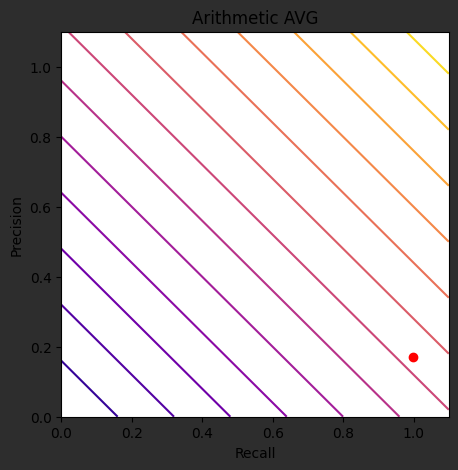

In [35]:
### Покажем на примере среднего арифметического, что должно у вас получиться

# Среднее арифметическое
metric_func = lambda x, y: (x + y)/2

# Среднее гармоническое
arithm_idx = (metric_func(precision, recall)).argmax()

# Распечатаем то же самое с округлением до 3 знаков после запятой
print(f"Precison:\t {precision[arithm_idx]:.3f}")
print(f"Recall: \t {recall[arithm_idx]:.3f}")
print(f"Threshold:\t {thres[arithm_idx]:.3f}")

# Построим график
level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

В данном коде мы определяем метрику `metric_func`, которая вычисляет среднее арифметическое между precision и recall. Затем мы находим индекс точки на кривой precision-recall, где `metric_func` достигает максимального значения, используя метод `argmax` и применяя `metric_func` к векторам `precision` и `recall`.

Далее, мы выводим значения precision, recall и threshold для этой точки на экран.

Наконец, мы строим график кривой precision-recall и отмечаем выбранную точку красным кругом, используя функцию `level_lines` для построения линий уровня метрики `metric_func`. В данном случае, максимум `metric_func` достигается в точке, где precision и recall примерно равны, поэтому мы выбрали метрику, которая учитывает равномерность восстановления классов.

В целом, данный код демонстрирует, как можно выбирать порог классификации на основе кривой precision-recall и как можно использовать различные метрики для оптимизации этого порога в зависимости от конкретных требований задачи.

Precison:	 0.223
Recall: 	 0.812
Threshold:	 0.125


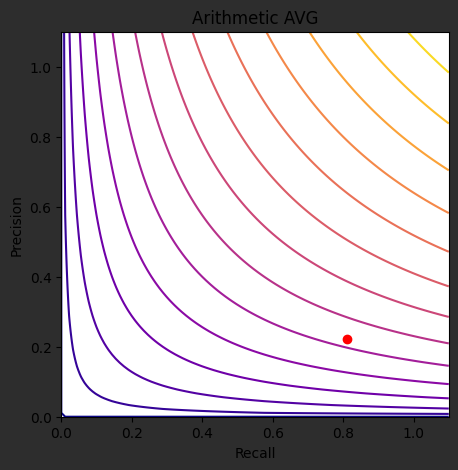

In [36]:
### Повторите для среднего геометрического

# Среднее геометрическое
metric_func = lambda x, y: (x * y)**0.5

# Среднее гармоническое
arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precison:\t {precision[arithm_idx]:.3f}")
print(f"Recall: \t {recall[arithm_idx]:.3f}")
print(f"Threshold:\t {thres[arithm_idx]:.3f}")

# Построим график
level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

В данном коде мы повторяем то же самое, что и в предыдущем коде, за исключением того, что мы теперь выбрали метрику `metric_func`, которая вычисляет среднее геометрическое между precision и recall. Эта метрика позволяет учитывать отношение между precision и recall и ориентирована на максимизацию F1-меры.

Затем мы находим индекс точки на кривой precision-recall, где `metric_func` достигает максимального значения, используя метод `argmax` и применяя `metric_func` к векторам `precision` и `recall`. Этот индекс соответствует точке на кривой, где мы можем выбрать порог таким образом, чтобы достичь максимального значения метрики `metric_func`.

Далее, мы выводим значения precision, recall и threshold для этой точки на экран.

Наконец, мы строим график кривой precision-recall и отмечаем выбранную точку красным кругом, используя функцию `level_lines` для построения линий уровня метрики `metric_func`.

F1-мера - это гармоническое среднее между точностью (precision) и полнотой (recall) модели классификации. F1-мера позволяет учитывать как точность, так и полноту при оценке качества модели, что делает ее более устойчивой к несбалансированным выборкам, где один класс преобладает над другим.

F1-мера вычисляется как:

F1 = 2 \* (precision \* recall) / (precision + recall)

где precision и recall вычисляются как:

precision = TP / (TP + FP)

recall = TP / (TP + FN)

где TP (True Positive) - число истинно положительных ответов, FP (False Positive) - число ложно положительных ответов, FN (False Negative) - число ложно отрицательных ответов.

Таким образом, F1-мера является балансом между точностью и полнотой, и хорошо подходит для оценки качества моделей в задачах бинарной классификации, когда оба класса имеют примерно равную важность.

Precison:	 0.359
Recall: 	 0.359
Threshold:	 0.237


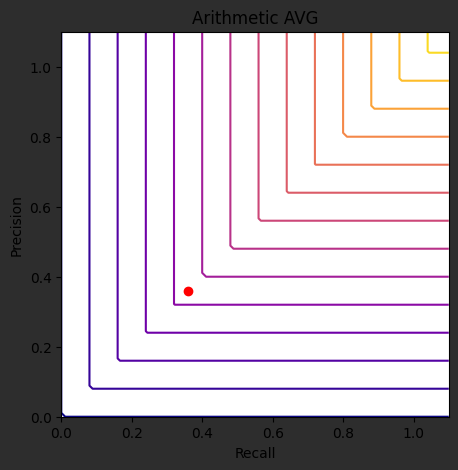

In [37]:
### Повторите для минимума

# Среднее геометрическое
metric_func = lambda x, y: np.minimum(x, y)

# Среднее гармоническое
arithm_idx = (metric_func(precision, recall)).argmax()

print(f"Precison:\t {precision[arithm_idx]:.3f}")
print(f"Recall: \t {recall[arithm_idx]:.3f}")
print(f"Threshold:\t {thres[arithm_idx]:.3f}")

# Построим график
level_lines(metric_func, "Arithmetic AVG")
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro');

В данном коде мы находим точку на кривой precision-recall, где метрика `metric_func` достигает максимального значения. Для этого мы сначала определяем функцию `metric_func`, которая принимает два аргумента - векторы `x` и `y` одинаковой длины и возвращает вектор, состоящий из минимальных значений элементов `x` и `y` поэлементно.

Затем мы находим индекс точки на кривой precision-recall, где `metric_func` достигает максимального значения, используя метод `argmax` и применяя `metric_func` к векторам `precision` и `recall`. Этот индекс соответствует точке на кривой, где мы можем выбрать порог таким образом, чтобы достичь максимального значения метрики `metric_func`.

Далее, мы выводим значения precision, recall и threshold для этой точки на экран.

Наконец, мы строим график кривой precision-recall и отмечаем выбранную точку красным кругом, используя функцию `level_lines` для построения линий уровня метрики `metric_func`.

В данном случае, мы выбрали метрику `metric_func`, которая вычисляет среднее геометрическое между precision и recall, то есть точку, в которой precision и recall достигают баланса между собой. Однако, можно использовать и другие метрики, например, среднее гармоническое, которое обладает свойством учитывать меньший из двух значений больше, чем больший.

**Задание 5.** Одним из самых распространенных показателей качества является **F-мера**, которая обобщает все вышерассмотренные метрики. Более того, в ней можно регулировать параметр $\beta^2$, который отвечает за предпочтение между precision и recall. 
$$
F = \dfrac{(1 + \beta^2) P \cdot R}{\beta^2 P + R}
$$
* При $\beta^2 = 1$ и precision, и recall нам важны в равной степени.
* При $\beta^2 > 1$ предпочтение отдается recall. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение precision и максимизируем recall.
* При $0 < \beta^2 < 1$ предпочтение отдается precision. Похоже на решение задачи, где мы фиксируем приемлемое для нас значение recall и максимизируем precision.

Найдите порог, который максимизирует:
1) F-меру с $\beta^2 = 1$,
2) F-меру с $\beta^2 = 0.05$,
3) F-меру с $\beta^2 = 4$.\
Для всех трех случаев выведите precision, recall, threshold и F-меру. 
Нарисуйте линии уровня и точку, которая максимизирует F-меру по аналогии с предыдущим пунктом.

Threshold:	 0.192
Precison:	 0.285
Recall: 	 0.525
F1 score: 	 0.369
0.192, 0.285, 0.525, 0.369


C:\Users\Alex\AppData\Local\Temp\ipykernel_15560\3994831761.py:10: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda x, y: ((1+b)*x*y)/(b*x+y)


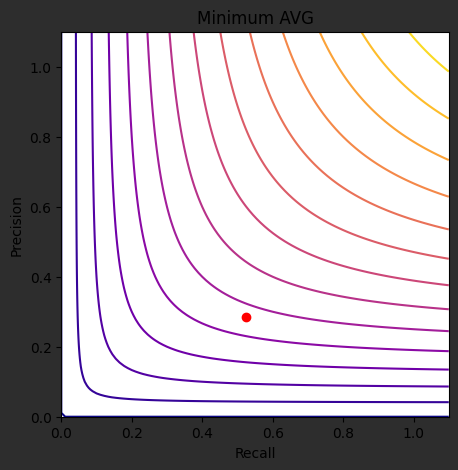

In [48]:
### Повторите для F-меры при \beta^2=1
### Выведите ее вместе с precision/recall/threshold


precision, recall, thres = precision_recall_curve(y_test, proba_test[:, 1])

b = 1

# Определяем метрику F-меры с коэффициентом баланса b
metric_func = lambda x, y: ((1+b)*x*y)/(b*x+y)

# Вычисляем индекс точки на кривой precision-recall, где метрика достигает максимального значения
arithm_idx = (metric_func(precision, recall)).argmax()

# Вычисляем порог, precision, recall и F1-меру в выбранной точке на кривой precision-recall
threshold = thres[arithm_idx]
precision_score = precision[arithm_idx]
recall_score = recall[arithm_idx]
f1_score = (1+b)*precision_score*recall_score/(b*precision_score+recall_score)

# Выводим значения на экран
print(f"Threshold:\t {threshold:.3f}")
print(f"Precison:\t {precision_score:.3f}")
print(f"Recall: \t {recall_score:.3f}")
print(f"F1 score: \t {f1_score:.3f}")

# Рисуем линии уровня метрики на графике precision-recall
level_lines(metric_func, "Minimum AVG")

# Отмечаем выбранную точку на графике precision-recall
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro')

# Выведите Threshold, Precision, Recall, F-мера через запятую и пробел с точностью до трех знаков после точки
print(f"{threshold:.3f}, {precision_score:.3f}, {recall_score:.3f}, {f1_score:.3f}")

Threshold:	 0.497
Precison:	 0.642
Recall: 	 0.109
F1 score: 	 0.521
0.497, 0.642, 0.109, 0.521


C:\Users\Alex\AppData\Local\Temp\ipykernel_15560\3614627716.py:10: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda x, y: ((1+b)*x*y)/(b*x+y)


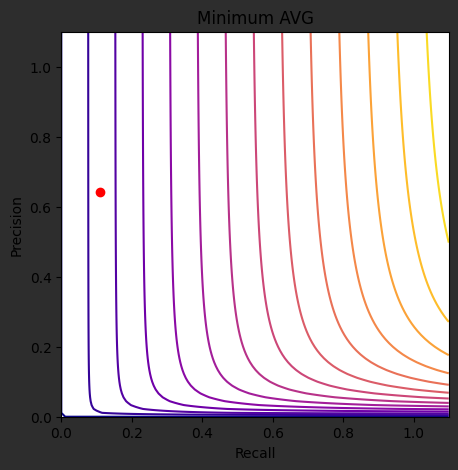

In [49]:
### Повторите для F-меры при \beta^2=0.05
### Выведите ее вместе с precision/recall/threshold
### Your code is here

b = 0.05

precision, recall, thres = precision_recall_curve(y_test, proba_test[:, 1])

# Определяем метрику F-меры с коэффициентом баланса b
metric_func = lambda x, y: ((1+b)*x*y)/(b*x+y)

# Вычисляем индекс точки на кривой precision-recall, где метрика достигает максимального значения
arithm_idx = (metric_func(precision, recall)).argmax()

# Вычисляем порог, precision, recall и F1-меру в выбранной точке на кривой precision-recall
threshold = thres[arithm_idx]
precision_score = precision[arithm_idx]
recall_score = recall[arithm_idx]
f1_score = (1+b)*precision_score*recall_score/(b*precision_score+recall_score)

# Выводим значения на экран
print(f"Threshold:\t {threshold:.3f}")
print(f"Precison:\t {precision_score:.3f}")
print(f"Recall: \t {recall_score:.3f}")
print(f"F1 score: \t {f1_score:.3f}")

# Рисуем линии уровня метрики на графике precision-recall
level_lines(metric_func, "Minimum AVG")

# Отмечаем выбранную точку на графике precision-recall
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro')

# Выведите Threshold, Precision, Recall, F-мера через запятую и пробел с точностью до трех знаков после точки
print(f"{threshold:.3f}, {precision_score:.3f}, {recall_score:.3f}, {f1_score:.3f}")

Threshold:	 0.108
Precison:	 0.210
Recall: 	 0.863
F1 score: 	 0.532
0.108, 0.210, 0.863, 0.532


C:\Users\Alex\AppData\Local\Temp\ipykernel_15560\358775072.py:10: RuntimeWarning: invalid value encountered in divide
  metric_func = lambda x, y: ((1+b)*x*y)/(b*x+y)


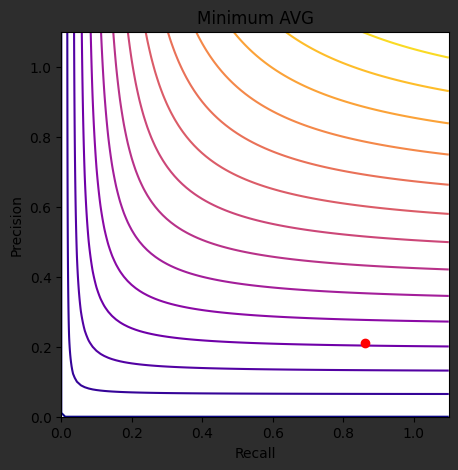

In [50]:
### Повторите для F-меры при \beta^2=4
### Выведите ее вместе с precision/recall/threshold
### Your code is here

b = 4

precision, recall, thres = precision_recall_curve(y_test, proba_test[:, 1])

# Определяем метрику F-меры с коэффициентом баланса b
metric_func = lambda x, y: ((1+b)*x*y)/(b*x+y)

# Вычисляем индекс точки на кривой precision-recall, где метрика достигает максимального значения
arithm_idx = (metric_func(precision, recall)).argmax()

# Вычисляем порог, precision, recall и F1-меру в выбранной точке на кривой precision-recall
threshold = thres[arithm_idx]
precision_score = precision[arithm_idx]
recall_score = recall[arithm_idx]
f1_score = (1+b)*precision_score*recall_score/(b*precision_score+recall_score)

# Выводим значения на экран
print(f"Threshold:\t {threshold:.3f}")
print(f"Precison:\t {precision_score:.3f}")
print(f"Recall: \t {recall_score:.3f}")
print(f"F1 score: \t {f1_score:.3f}")

# Рисуем линии уровня метрики на графике precision-recall
level_lines(metric_func, "Minimum AVG")

# Отмечаем выбранную точку на графике precision-recall
plt.plot(recall[arithm_idx], precision[arithm_idx], 'ro')

# Выведите Threshold, Precision, Recall, F-мера через запятую и пробел с точностью до трех знаков после точки
print(f"{threshold:.3f}, {precision_score:.3f}, {recall_score:.3f}, {f1_score:.3f}")